# Test Acc 성능을 높이기 위한 방안
- Derived Variable 생성해서 다시 학습
    - 결과: 시계열 데이터 피쳐 추출 (aeon : 시계열 데이터 Classification - Feature Based 라이브러리 사용)
        - Catch 22 (이상치 비율, 자기 상관지수(autoCorrelation), ...) 성능: 0.549
        - SummaryClassifier (평균, 편차, ...) : 0.592
- Model 변경
    - 결과: 유의미한 결과 없음
    - 성능은 0.69를 넘지 못함
- 최적화 (Grid Search)
    - 결과: 유의미한 결과 없음
    - 성능은 0.69를 넘지 못함

# 모델 변경
추가) 클래스 불균형 반영 : 07/30
- LightGBM
- CatBoost
- XGBoost

In [1]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from lightgbm import DaskLGBMClassifier, LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier, XGBRFClassifier
from warnings import filterwarnings
filterwarnings('ignore')
from sklearn.model_selection import train_test_split
pd.set_option('display.max_columns', None)

# 윈도우 기준 예시 (맑은 고딕)
rc('font', family='Malgun Gothic')
def init():
    walk_target = pd.read_csv('LifeLog\Data\\1.Training\라벨링데이터\\1.걸음걸이\\training_label.csv').rename(columns={'SAMPLE_EMAIL':"EMAIL"})
    walk_lifelog = pd.read_csv('LifeLog\Data\\1.Training\원천데이터\\1.걸음걸이\\train_activity.csv')
    walk_df = walk_lifelog.merge(walk_target,on='EMAIL')
    walk_df.rename(columns={
        'activity_average_met': '하루간 평균 MET',
        'activity_cal_active': '하루간 활동 칼로리',
        'activity_cal_total': '하루간 총 사용 칼로리',
        'activity_class_5min': '하루간 5분당 활동 로그',
        'activity_daily_movement': '매일 움직인 거리',
        'activity_day_end': '활동 종료 시간',
        'activity_day_start': '활동 시작 시간',
        'activity_high': '고강도 활동 시간',
        'activity_inactive': '비활동 시간',
        'activity_inactivity_alerts': '비활동 알람 횟수',
        'active_low': '저강도 활동 시간',
        'activity_medium': '중강도 활동 시간',
        'activity_met_1min': '하루간 1분 당 MET 로그',
        'activity_met_min_high': '하루간 고강도 활동 MET',
        'activity_met_min_inactive': '하루간 비활동 MET',
        'activity_met_min_low': '하루간 저강도 활동 MET',
        'activity_met_min_medium': '하루간 중강도 활동 MET',
        'activity_non_wear': '미착용 시간',
        'activity_rest': '휴식 시간',
        'activity_score': '활동 점수',
        'activity_low':'저강도 활동 시간',
        'activity_score_meet_daily_targets': '활동 목표달성 점수',
        'activity_score_move_every_hour': '매 시간 당 활동유지 점수',
        'activity_score_recovery_time': '회복시간 점수',
        'activity_score_stay_active': '활동 유지 점수',
        'activity_score_training_frequency': '운동 빈도 점수',
        'activity_score_training_volume': '운동량 점수',
        'activity_steps': '매일 걸음 수',
        'activity_total': '활동 총 시간(분)',
        'CONVERT(activity_class_5min USING utf8)': '하루간 5분당 활동 로그 (UTF-8)',
        'CONVERT(activity_met_1min USING utf8)': '하루간 1분당 MET 로그 (UTF-8)',
        'EMAIL': '이메일',
        'DIAG_NM': '진단명'
    }, inplace=True)
    return walk_df

selected_columns = ['하루간 평균 MET','하루간 활동 칼로리','하루간 총 사용 칼로리','비활동 시간','비활동 알람 횟수','저강도 활동 시간','하루간 비활동 MET',
                    '하루간 저강도 활동 MET','활동 점수','활동 목표달성 점수','회복시간 점수','활동 유지 점수','운동량 점수','매일 걸음 수','활동 총 시간(분)','진단명']

def feature_selection(df, columns:list):
    return df[columns]

def separate(df):
    X = df.drop(columns='진단명')
    y = df[['진단명']]
    le = LabelEncoder()
    y = le.fit_transform(y)
    print(le.classes_)
    return train_test_split(X,y,test_size=0.2,stratify=y)

def train_and_evaluate(model, X_train, y_train, X_test, y_test, scale=False):
    if scale:
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', model)
        ])
        pipeline.fit(X_train, y_train)
        train_score = pipeline.score(X_train, y_train)
        test_score = pipeline.score(X_test, y_test)
        feature_importances = None
    else:
        model.fit(X_train, y_train)
        train_score = model.score(X_train, y_train)
        test_score = model.score(X_test, y_test)
        feature_importances = getattr(model, 'feature_importances_', None)
    print(f"Model: {model}")
    print(f"Train accuracy: {train_score:.4f}")
    print(f"Test accuracy: {test_score:.4f}")
    if feature_importances is not None:
        print("Feature importances:", feature_importances)
    print(f'feature_names: {X_train.columns.tolist()}')
    print()

    return {'feature_importances': feature_importances, 'train_score':train_score, 'test_score':test_score, 'feature_names': X_train.columns.tolist()}

def plot_feature_importances(feature_importances, feature_names, model_name):
    if feature_importances is None:
        print(f"{model_name}에는 feature_importances가 없습니다.")
        return
    
    indices = np.argsort(feature_importances)[::-1]  # 중요도 내림차순 정렬
    
    plt.figure(figsize=(8,4))
    plt.title(f"{model_name} Feature Importances")
    plt.bar(range(len(feature_importances)), feature_importances[indices], align='center')
    plt.xticks(range(len(feature_importances)), [feature_names[i] for i in indices], rotation=90)
    plt.ylabel("Importance")
    plt.tight_layout()
    plt.show()

<>:22: SyntaxWarning: invalid escape sequence '\D'
<>:23: SyntaxWarning: invalid escape sequence '\D'
<>:22: SyntaxWarning: invalid escape sequence '\D'
<>:23: SyntaxWarning: invalid escape sequence '\D'
C:\Users\human-02\AppData\Local\Temp\ipykernel_18060\2008694892.py:22: SyntaxWarning: invalid escape sequence '\D'
  walk_target = pd.read_csv('LifeLog\Data\\1.Training\라벨링데이터\\1.걸음걸이\\training_label.csv').rename(columns={'SAMPLE_EMAIL':"EMAIL"})
C:\Users\human-02\AppData\Local\Temp\ipykernel_18060\2008694892.py:23: SyntaxWarning: invalid escape sequence '\D'
  walk_lifelog = pd.read_csv('LifeLog\Data\\1.Training\원천데이터\\1.걸음걸이\\train_activity.csv')


In [2]:
df = init()
selected_df = feature_selection(df, selected_columns)
X_train, X_test, y_train, y_test = separate(selected_df)
RF_result = train_and_evaluate(RandomForestClassifier(class_weight='balanced',n_estimators=200), X_train, y_train, X_test,y_test)
GBC_result = train_and_evaluate(GradientBoostingClassifier(), X_train, y_train, X_test,y_test)
Ada_result = train_and_evaluate(AdaBoostClassifier(), X_train, y_train, X_test,y_test)
KNN_result = train_and_evaluate(KNeighborsClassifier(), X_train, y_train, X_test, y_test, scale=True)
SVC_result = train_and_evaluate(SVC(class_weight='balanced'), X_train, y_train, X_test, y_test, scale=True)
DT_result = train_and_evaluate(DecisionTreeClassifier(class_weight='balanced'), X_train, y_train, X_test, y_test)
XGBRF_result = train_and_evaluate(XGBRFClassifier(), X_train, y_train, X_test, y_test)
XGB_result = train_and_evaluate(XGBClassifier(), X_train, y_train, X_test, y_test)
LGBM_result = train_and_evaluate(LGBMClassifier(class_weight='balanced'), X_train, y_train, X_test, y_test)
CatBoost_result = train_and_evaluate(CatBoostClassifier(), X_train, y_train, X_test, y_test)

['CN' 'Dem' 'MCI']
Model: RandomForestClassifier(class_weight='balanced', n_estimators=200)
Train accuracy: 1.0000
Test accuracy: 0.6589
Feature importances: [0.04785675 0.08317364 0.0977538  0.08254576 0.01630524 0.08969857
 0.05607753 0.09556923 0.06159078 0.0516407  0.02290873 0.0670179
 0.05738119 0.08619784 0.08428233]
feature_names: ['하루간 평균 MET', '하루간 활동 칼로리', '하루간 총 사용 칼로리', '비활동 시간', '비활동 알람 횟수', '저강도 활동 시간', '하루간 비활동 MET', '하루간 저강도 활동 MET', '활동 점수', '활동 목표달성 점수', '회복시간 점수', '활동 유지 점수', '운동량 점수', '매일 걸음 수', '활동 총 시간(분)']

Model: GradientBoostingClassifier()
Train accuracy: 0.7005
Test accuracy: 0.6517
Feature importances: [0.04422774 0.08048416 0.18449592 0.05891283 0.03132949 0.07620766
 0.05331153 0.05957078 0.05653896 0.07595992 0.0190776  0.05054678
 0.08621514 0.08576247 0.03735901]
feature_names: ['하루간 평균 MET', '하루간 활동 칼로리', '하루간 총 사용 칼로리', '비활동 시간', '비활동 알람 횟수', '저강도 활동 시간', '하루간 비활동 MET', '하루간 저강도 활동 MET', '활동 점수', '활동 목표달성 점수', '회복시간 점수', '활동 유지 점수', '운동량 점수', '매일 걸음 

# 모델 변경에 대한 결론
- 모델의 한계성 (시계열성의 데이터를 이해할 수 없다.)

이유: 

    Tree 기반의 모델인 (Decision Tree, RandomForest, LightGBM, GradientBoosting, XGBoost)들은 시계열 데이터를 각각 개별의 독립적인 데이터로 인식하게 되어, 시계열성을 배제하게 된다. 따라서, 이러한 시계열성의 데이터를 반영할 수 있는 딥러닝 모델인 (RNN 계열의 모델: RNN, LSTM, GRU 모델) 또는 Attention 기반의 모델인 BERT, Transformer를 사용해 데이터를 분류할 필요성이 보인다.

결론:

    - 데이터들은 이미 하루 단위로 요약 피쳐로 존재하기 때문에, 더 이상 시계열성의 Feature를 파생변수를 만들 필요성이 없다고 판단했다. 
    다른 데이터셋을 추가하여, 치매를 분류할 수 있는 좋은 변수를 더하는 것이 좋겠다고 판단을 했다.

    - 머신러닝으로는 분류 성능이 저조하다.

    - Grid Search 진행 (clear)

    - ~Bayesian Model로 평균을 사용해 분류를 진행하는 것을 시도하고, 이마저도 성능이 낮다면, 데이터셋을 추가하는 것으로 한다.~


# 최적화 진행해 성능 향상 도모

In [3]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
param_grid = {
    'n_estimators': [100, 200, 300],              # 트리 개수
    'max_depth': [None, 5, 10],               # 트리 최대 깊이
    'min_samples_split': [2, 5, 10],              # 내부 노드 분할 최소 샘플 수
    'min_samples_leaf': [1, 2, 4],                # 리프 노드 최소 샘플 수
}
rf_grid = GridSearchCV(RandomForestClassifier(class_weight='balanced',random_state=42,n_jobs=-1), param_grid, verbose=2, cv=3, scoring='accuracy',n_jobs=-1)
rf_grid.fit(X_train, y_train)
rf_best = rf_grid.best_estimator_

# 2. XGBoost
xgb_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6],
    'learning_rate': [0.01]
}
xgb_grid = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
                        xgb_params, cv=3, scoring='accuracy')
xgb_grid.fit(X_train, y_train)
xgb_best = xgb_grid.best_estimator_

# 3. LightGBM
lgbm_params = {
    'n_estimators': [100, 200],
    'max_depth': [-1, 10],
    'learning_rate': [0.01]
}
lgbm_grid = GridSearchCV(LGBMClassifier(random_state=42), lgbm_params, cv=3, scoring='accuracy')
lgbm_grid.fit(X_train, y_train)
lgbm_best = lgbm_grid.best_estimator_

Fitting 3 folds for each of 81 candidates, totalling 243 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2118
[LightGBM] [Info] Number of data points in the train set: 5176, number of used features: 15
[LightGBM] [Info] Start training from score -0.518129
[LightGBM] [Info] Start training from score -2.831476
[LightGBM] [Info] Start training from score -1.062935
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000379 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2117
[LightGBM] [Info] Number of data points in the train set: 5176, number of used features: 15
[LightGBM] [Info] Start training from sc

In [4]:
import joblib
joblib.dump(rf_best,'RF_BESTMODEL.pkl')

['RF_BESTMODEL.pkl']

In [5]:
rf_pred = rf_best.predict(X_test)
print(np.equal(rf_pred,y_test).sum()/len(rf_pred))

lgbm_pred = lgbm_best.predict(X_test)
print(np.equal(lgbm_pred,y_test).sum()/len(lgbm_pred))

xgb_pred = xgb_best.predict(X_test)
print(np.equal(xgb_pred,y_test).sum()/len(xgb_pred))

0.6594538897475528
0.6537867078825348
0.6476043276661515


In [6]:
rf_best.predict_proba(X_test)[1]

array([0.43, 0.  , 0.57])

# 시계열 데이터 Feature Extraction Based Model 
- SummaryClassifier : (mean, std, min, max, 0.25, 0.5, 0.75)를 추출해서 분류 모델 예측
- Catch22 : 22개의 Canonical한 특성 (주기성, 계절성, 변동성, ...)

## Summary Classifier

In [7]:
from aeon.classification.feature_based import SummaryClassifier
clf = SummaryClassifier(n_jobs=-1, estimator=RandomForestClassifier(n_estimators=5))
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
np.equal(y_pred,y_test).sum()/len(lgbm_pred)

np.float64(0.5466254507985574)

## Catch22

In [8]:
from aeon.transformations.collection.feature_based import Catch22
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
import numpy as np

# Transformer 적용
transformer = Catch22(n_jobs=-1)
X_feat_train = transformer.fit_transform(X_train, y_train)
X_feat_test = transformer.transform(X_test)    # y_test 제거

# 결측치 처리 (필요 시)
imputer = SimpleImputer(strategy='mean')
X_feat_train = imputer.fit_transform(X_feat_train)
X_feat_test = imputer.transform(X_feat_test)

# classifier 학습
clf = RandomForestClassifier()
clf.fit(X_feat_train, y_train)

# 예측 및 평가
y_pred = clf.predict(X_feat_test)
acc = np.mean(y_pred == y_test)
print("Accuracy:", acc)

Accuracy: 0.5806285419886656


In [9]:
X_feat_train

array([[1.64740000e+03, 8.23700000e+02, 5.82359348e-01, ...,
        1.77213939e+00, 1.57079633e+00, 5.14815479e+03],
       [5.96765625e+02, 2.99085938e+02, 5.83832523e-01, ...,
        2.00755631e+00, 1.57079633e+00, 1.87267491e+03],
       [1.23410000e+03, 6.17550000e+02, 5.79070553e-01, ...,
        1.77213939e+00, 1.57079633e+00, 3.87365763e+03],
       ...,
       [2.15200000e+02, 1.07600000e+02, 5.96926461e-01, ...,
        1.90853528e+00, 1.57079633e+00, 7.44890890e+02],
       [1.93570000e+03, 9.67850000e+02, 5.83671082e-01, ...,
        1.97018144e+00, 1.57079633e+00, 6.05546015e+03],
       [1.50910000e+03, 7.54550000e+02, 5.84038464e-01, ...,
        1.97018144e+00, 1.57079633e+00, 4.72734255e+03]], shape=(7764, 20))

=> 20개의 시계열 Features

# 베이지안 모델 (시계열성이 포함된)

Bayesian Model로 평균을 사용해 분류를 진행하는 것을 시도하고, 이마저도 성능이 낮다면, 데이터셋을 추가하는 것으로 한다.

In [10]:
selected_df.groupby('진단명').mean()

,하루간 평균 MET,하루간 활동 칼로리,하루간 총 사용 칼로리,비활동 시간,비활동 알람 횟수,저강도 활동 시간,하루간 비활동 MET,하루간 저강도 활동 MET,활동 점수,활동 목표달성 점수,회복시간 점수,활동 유지 점수,운동량 점수,매일 걸음 수,활동 총 시간(분)
진단명,,,,,,,,,,,,,,,
CN,1.471274,466.329182,2490.928905,523.649196,0.509600,282.430029,7.784120,192.782737,82.476734,76.198409,85.363259,77.185089,87.640720,10666.965577,338.620308
Dem,1.383483,400.504378,2425.490368,479.168126,0.381786,213.781086,6.464098,149.569177,74.486865,46.844133,90.357268,81.656743,76.739054,8788.700525,262.921191
MCI,1.484892,483.042052,2544.159559,497.246048,0.330152,310.628691,8.229943,209.276171,84.698777,79.360274,86.942440,80.343275,89.056367,11186.545183,366.751864


              precision    recall  f1-score   support

           0       0.63      0.45      0.53      1156
           1       0.15      0.30      0.20       114
           2       0.41      0.54      0.47       671

    accuracy                           0.48      1941
   macro avg       0.40      0.43      0.40      1941
weighted avg       0.53      0.48      0.49      1941



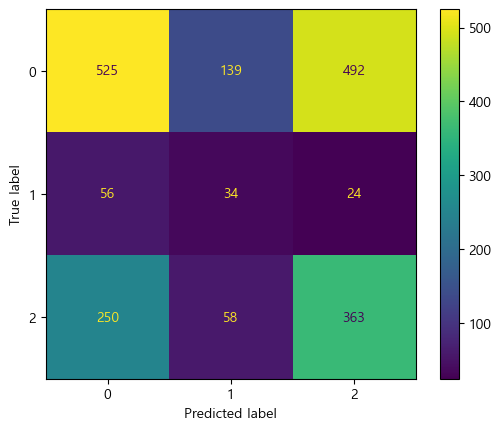

In [15]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
# 베이지안 모델 학습
clf = GaussianNB()
clf.fit(X_train, y_train)

# 예측 및 평가
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred,labels = clf.classes_)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

# 모델 & 데이터 저장

(7764, 15) (1941, 15) (7764,) (1941,)


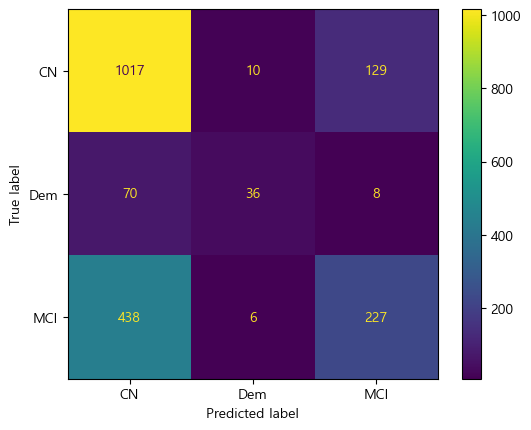

              precision    recall  f1-score   support

           0       0.67      0.88      0.76      1156
           1       0.69      0.32      0.43       114
           2       0.62      0.34      0.44       671

    accuracy                           0.66      1941
   macro avg       0.66      0.51      0.54      1941
weighted avg       0.65      0.66      0.63      1941



In [ ]:
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

model = joblib.load('RF_BESTMODEL.pkl')
y_pred = model.predict(X_test)

# 혼동 행렬 계산
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)

# 혼동 행렬 시각화
disp = ConfusionMatrixDisplay(cm,display_labels=['CN','Dem','MCI'],)
disp.plot()
plt.show()

print(classification_report(y_test,y_pred))

# 분석
- Recall: $\frac{모델이\; 치매라고\; 예측한\; 수}{실제\; 치매환자의\;수}$

- Precision: $\frac{실제\;치매환자의 \;수}{모델이 \; 치매라고 \; 예측한 \; 수}$

특히, 실제 Dem(1) 치매환자인데, 모델이 치매라고 맞추는 비율이 낮다. 또한, MCI도 비슷한 증상을 갖는다.